# Code for generating Figure 3

## "Generalization of a 2D data distribution depends on features used and data orientation"

This Python notebook contains code for generating the third figure from the ICLR 2025 paper "[Generalization through variance: how noise shapes inductive biases in diffusion models](https://openreview.net/forum?id=7lUdo8Vuqa)". It depends on two files, `general_functions.py` and `linear_functions_2d.py`, that are in the `functions/` folder.

In [14]:
# imports
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from functions.general_functions import get_time_funcs, get_prob_from_samples
from functions.linear_functions_2d import phi_gauss, phi_fourier, get_phi_crossed_func_2d, get_phi_crossed_grid   # feature functions
from functions.linear_functions_2d import train_phi_denoise, sample_PF_ODE_2d_batched              # training and sampling

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<center>
<img src="fig3_feat_noise.png" width="700"/></center>

Generalization of a 2D data distribution depends on features used and data orientation. Heatmaps of samples from $N = 100$ linear models are shown in different conditions, with training data (red dots) overlaid. Notice that which gaps are `filled in', e.g., whether a square shape or cross shape is made, depends on both factors.

---------

## 2D generalization depends on feature set and data distribution orientation

Set up parameter choices.

In [16]:
th_list = np.array([0, np.pi/8, np.pi/4]); num_th = len(th_list)   # number of different data dist rotations to consider
feat_list = ['gauss', 'fourier']; num_types = len(feat_list)       # different feature set categories to consider

num_train_samples = 500          # number of samples used to train models
num_models = 100                 # number of linear models to train
num_samples = int(1e5)           # number of samples to draw from trained models, used to visualize learned distributions


# number of features
F_x = 10                 # number of x features
F_y = 10                 # number of y features
F_t = 10                 # number of t features
F_ = np.array([F_x, F_y, F_t])
F = F_x*F_y*F_t   # = 10^3 = 1000


# define grids of x and y values, used for sampling and visualization
num_x = 200; x_min = -1.5; x_max = 1.5
x = np.linspace(x_min, x_max, num_x); dx = x[1] - x[0]

num_y = 200; y_min = -1.5; y_max = 1.5
y = np.linspace(y_min, y_max, num_y); dy = y[1] - y[0]


# define forward process and noise schedule 
beta_min, beta_d = 0.1, 19.9; rho=7; params_time = {'beta_min':beta_min, 'beta_d':beta_d, 'rho':rho}
eps, T, num_tsteps = 1e-2, 1, 30; 
t, t_lin, time_funcs = get_time_funcs(eps, T, num_tsteps, params_time, option='VP')

Train many linear models, store average learned distribution.

In [20]:
prob_avg_list = np.zeros((num_types, num_th, num_x, num_y))

for r in range(num_types):
    for c in range(num_th):
        print(r, c)
        feature_type = feat_list[r]
        th = th_list[c]

        # get data
        x_data = []
        for i in range(4):
            x_data.append([np.cos(i*2*np.pi/4 + th), np.sin(i*2*np.pi/4 + th)])
        x_data = np.array(x_data)

        # get features
        if feature_type == 'fourier':
            phi_x_func = lambda x : phi_fourier(x, F_x, x_min, x_max)
            phi_y_func = lambda y : phi_fourier(y, F_y, y_min, y_max)
            phi_t_func = lambda t : phi_fourier(t, F_t, eps, T)
        elif feature_type == 'gauss':
            x_proto = np.linspace(x_min, x_max, F_x); dx_proto = x_proto[1] - x_proto[0]
            y_proto = np.linspace(y_min, y_max, F_y); dy_proto = y_proto[1] - y_proto[0]
            t_proto = np.linspace(eps, T, F_t); dt_proto = t_proto[1] - t_proto[0]
                
            phi_x_func = lambda a : phi_gauss(a, x_proto, dx_proto*np.ones_like(x_proto)/2., sig_scale=1.)
            phi_y_func = lambda a : phi_gauss(a, y_proto, dy_proto*np.ones_like(y_proto)/2., sig_scale=1.)
            phi_t_func = lambda a : phi_gauss(a, t_proto, dt_proto*np.ones_like(t_proto)/2., sig_scale=1.)
            
        phi_funcs = (phi_x_func, phi_y_func, phi_t_func)
        phi_func = lambda z, t : get_phi_crossed_func_2d(z, t, phi_funcs, F)
        phi_grid = get_phi_crossed_grid(x, y, t, phi_funcs, F)

        # train model
        W, Sig_phi, A_phi = train_phi_denoise(x_data, phi_func, num_train_samples, num_models, time_funcs, eps_reg=0.1)

        mu_est = np.einsum('bdf,xytf->bdxyt', W , phi_grid, optimize=True) 
        print('computed mu_est')

        # get samples
        x_t, y_t = sample_PF_ODE_2d_batched(num_samples, x, y, t, time_funcs, mu_est)

        # get hist
        z_t = np.array([x_t, y_t]).transpose(1,0,2)
        print(z_t.shape)
        
        n_bins = 200
        L_half = 1.5
        z_min = np.array([-L_half,-L_half])
        z_max = np.array([L_half,L_half])
        prob = get_prob_from_samples(z_t, n_bins, z_min, z_max)
        print(prob.shape)

        prob_avg = np.mean(prob, axis=0)
        prob_avg_list[r,c] = prob_avg
        print()
print('Done!')

0 0
computed empirical matrices
inverted Sig_phi
computed W
computed mu_est
(100, 2, 100000)
(100, 200, 200)

0 1
computed empirical matrices
inverted Sig_phi
computed W
computed mu_est
(100, 2, 100000)
(100, 200, 200)

0 2
computed empirical matrices
inverted Sig_phi
computed W
computed mu_est
(100, 2, 100000)
(100, 200, 200)

1 0
computed empirical matrices
inverted Sig_phi
computed W
computed mu_est
(100, 2, 100000)
(100, 200, 200)

1 1
computed empirical matrices
inverted Sig_phi
computed W
computed mu_est
(100, 2, 100000)
(100, 200, 200)

1 2
computed empirical matrices
inverted Sig_phi
computed W
computed mu_est
(100, 2, 100000)
(100, 200, 200)

Done!


Plot figure.

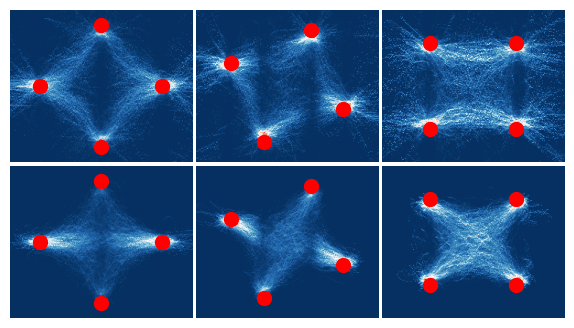

In [22]:
lw = 2

fig, ax = plt.subplots(ncols=num_th, nrows=num_types, figsize=(8,4), sharex=True, sharey=True)

for r in range(num_types):
    for c in range(num_th):
        x_data = []
        for i in range(4):
            x_data.append([np.cos(i*2*np.pi/4 + th_list[c]), np.sin(i*2*np.pi/4 + th_list[c]) - 0.25])
        x_data = np.array(x_data) 
        
        ax[r, c].imshow(prob_avg_list[r,c], origin='lower', extent=(-1.5, 1.5, -1.5, 1,5), cmap='RdBu_r')
        ax[r,c].invert_yaxis() 
        ax[r, c].scatter(x_data[:,0], x_data[:,1], color='red',s=100)

        ax[r, c].spines['top'].set_visible(False)
        ax[r, c].spines['right'].set_visible(False)
        ax[r, c].spines['left'].set_visible(False)
        ax[r, c].spines['bottom'].set_visible(False)
        ax[r, c].axis('off')
        ax[r, c].set_aspect(1)

plt.subplots_adjust(wspace=-0.25, hspace=0.025)

plt.savefig('results/fig-feat-noise'+'.png', bbox_inches='tight', transparent=True)
plt.savefig('results/fig-feat-noise'+'.pdf', bbox_inches='tight', transparent=True)
plt.savefig('results/fig-feat-noise'+'.svg', bbox_inches='tight', transparent=True)
plt.show()

## Cartoons: visualizing Gaussian and Fourier features

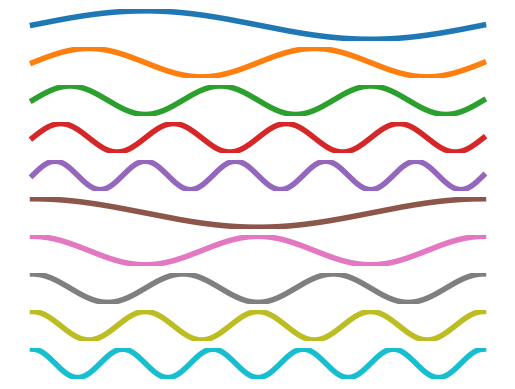

In [10]:
z_min, z_max = 0, 1
num_z = 200
z = np.linspace(z_min, z_max, num_z)

num_F = 10
n = np.arange(1, num_F/2 + 1)
cosines = np.cos(2*np.pi*n[None,:]*z[:,None])
sines = np.sin(2*np.pi*n[None,:]*z[:,None])

fig, ax = plt.subplots(nrows=num_F)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    ax[i].plot(z, sines[:,i], linewidth=4, color=colors[i])
    ax[i].axis('off')
for i in range(5):
    ax[i+5].plot(z, cosines[:,i], linewidth=4, color=colors[i+5])
#plt.plot(z, cosines, linewidth=4)
    ax[i+5].axis('off')
plt.savefig('results/cartoon-fourier'+'.png', bbox_inches='tight', transparent=True)
plt.savefig('results/cartoon-fourier'+'.pdf', bbox_inches='tight', transparent=True)
plt.savefig('results/cartoon-fourier'+'.svg', bbox_inches='tight', transparent=True)
plt.show()

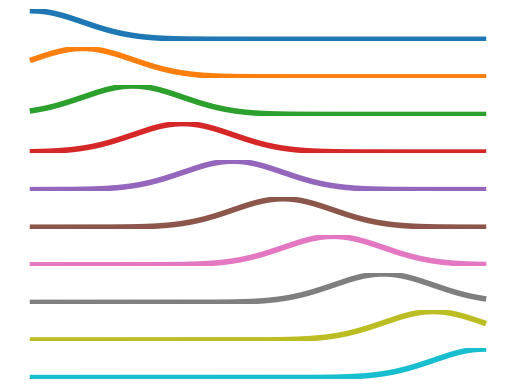

In [12]:
z_min, z_max = 0, 1
num_z = 200
z = np.linspace(z_min, z_max, num_z)

num_F = 10
mu = np.linspace(z_min, z_max, num_F)
dmu = mu[1] - mu[0]
bumps = norm.pdf(z[:,None], loc=mu[None,:], scale=dmu)

fig, ax = plt.subplots(nrows=num_F)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(num_F):
    ax[i].plot(z, bumps[:,i], linewidth=4, color=colors[i])
    ax[i].axis('off')

plt.savefig('results/cartoon-gauss'+'.png', bbox_inches='tight', transparent=True)
plt.savefig('results/cartoon-gauss'+'.pdf', bbox_inches='tight', transparent=True)
plt.savefig('results/cartoon-gauss'+'.svg', bbox_inches='tight', transparent=True)
plt.show()